Внимательно прочтите эти инструкции. Выполнение **всех** этих пунктов - обязательно для получения баллов за задание.

1) Проверка
    - После того, как вы допишете код
        - очистите все клетки (`Cell > All Output > Clear`)
        - выполните все клетки подряд (`Cell > Run All`)
    - Выполнение должно пройти без ошибок
    - Сохраните ноутбук с выполненными клетками

<!-- -->

2) Отправка в тестовую систему
    - Когда вы готовы сдать ноутбук, загрузите его в тестовую систему (fall.cv-gml.ru)
    - В тестовую систему нужно загружать только сам `.ipynb` ноутбук
        - Не нужно его `zip`овать
        - Не нужно его конвертировать в `pdf` или `html`
    - После загрузки в тестовую систему там появится ссылка для просмотра загруженного решения
        - Проверьте, что вы загрузили в тестовую систему то, что хотели
        - Проверьте, что в системе отображаются результаты выполнения всех клеток

## NeRF

Необходимо реализовать базовую версию [NeRF](https://arxiv.org/pdf/2003.08934.pdf) не включающую иерархический семплинг (его тоже можно реализовать, если есть желание). Код загрузки данных вам предоставлен, рекомендуется внимательно его изучить.

Работы оцениваются по бинарному принципу (зачет/незачет).

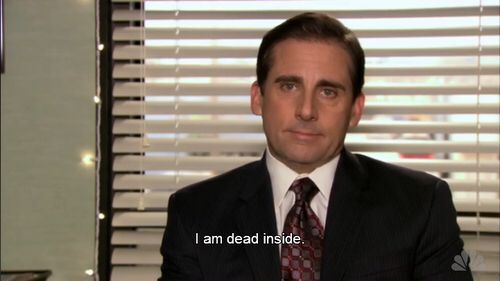

In [1]:
!git clone https://github.com/NVlabs/nvdiffrast
!cd nvdiffrast/ && pip install .
!pip install ninja

Cloning into 'nvdiffrast'...
remote: Enumerating objects: 330, done.
remote: Counting objects: 100% (330/330), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 330 (delta 162), reused 302 (delta 155), pack-reused 0
Receiving objects: 100% (330/330), 11.10 MiB | 25.03 MiB/s, done.
Resolving deltas: 100% (162/162), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/nvdiffrast
  Preparing metadata (setup.py) ... done
  Created wheel for nvdiffrast: filename=nvdiffrast-0.3.0-py3-none-any.whl size=137442 sha256=7ea0828eb6975607b7e2958fefce7593fb688b2ddadf69ba0c669e1f45817aa6
  Stored in directory: /tmp/pip-ephem-wheel-cache-j4e02euc/wheels/67/e2/b5/3fa076e0fcbccd4c905697ddace64532cc1ace4d7aeef2b786
Successfully built nvdiffrast
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 3.2 MB/s eta

In [2]:

!pip install trimesh
!pip install xatlas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.5/680.5 KB 12.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.5/229.5 KB 5.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt


import nvdiffrast.torch as dr
glctx = dr.RasterizeGLContext()

In [5]:
from tqdm import tqdm

In [6]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/nerv/')

In [7]:
from lib.dataset import DatasetNERF
dataset = DatasetNERF(cfg="/content/drive/MyDrive/nerv/data/hotdog/transforms_train.json", near=2.0, far=6.0, resolution=(160, 160), ray_mode=True)

In [21]:
from torch import nn
class VanillaNeRF(torch.nn.Module):
    """
    Реализуйте конфигурацию NeRF согласно статье: https://arxiv.org/pdf/2003.08934.pdf
  
    """

    def __init__(self, embedding_dim_pos=10, embedding_dim_direction=4, hidden_dim=128):
        super(VanillaNeRF, self).__init__()

        self.block1 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), )

        self.block2 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + hidden_dim + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1), )

        self.block3 = nn.Sequential(nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2), nn.ReLU(), )
        self.block4 = nn.Sequential(nn.Linear(hidden_dim // 2, 3), nn.Sigmoid(), )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        # print("Nerf forward: ")
        emb_x = self.positional_encoding(o, self.embedding_dim_pos)
        emb_d = self.positional_encoding(d, self.embedding_dim_direction)
        # print("Emb x/ Emb d shape: ", emb_x.shape, emb_d.shape)
        h = self.block1(emb_x)
        # print(h.shape)
        tmp = self.block2(torch.cat((h, emb_x), dim=1))
        # print(tmp.shape)
        h, sigma = tmp[:, :-1], self.relu(tmp[:, -1])
        h = self.block3(torch.cat((h, emb_d), dim=1))
        c = self.block4(h)
        # print("End of forward")
        return c, sigma

In [17]:
def render_radiance_field(imv, coords, radiance_field_fn, focal, resolution, near=2., far=6., bins=64, train=True, chunk=1024):
    imv = torch.tensor(imv, dtype=torch.float32, device='cuda') if not torch.is_tensor(imv) else imv

    if train:
        ray_o, ray_d = ray_gen(imv, coords, focal, resolution)
        ray_o = ray_o.to(device='cuda')
        ray_d = ray_d.to(device='cuda')
        # print("rays shape: ", ray_o.shape, ray_d.shape)
        color = ray_color(ray_o, ray_d, radiance_field_fn, near, far, bins)

        return color
    with torch.no_grad():
        H, W = resolution
        u, v = torch.meshgrid(torch.linspace(0, W-1, W), 
                                torch.linspace(0, H-1, H))
        coords = torch.stack([v.T.flatten(), u.T.flatten()], dim=-1)
        ray_o, ray_d = ray_gen(imv[0:1, ...], coords, focal, resolution)
        # print("Shape of rays: ", ray_o.shape, ray_d.shape)
        ray_o = ray_o.expand([ray_d.shape[0], -1])
        # print("Shape of rays: ", ray_o.shape, ray_d.shape)

        steps = ray_o.shape[0] // chunk + (ray_o.shape[0] % chunk > 0)

        color = torch.stack(
            [
                ray_color(
                    ray_o[i*chunk : (i+1)*chunk], 
                    ray_d[i*chunk : (i+1)*chunk],
                    radiance_field_fn,
                    near,
                    far,
                    bins
                )
            for i in range(steps)]
        )
        return color.view(*resolution, 3)


In [18]:
def ray_gen(imv, coords, focal, resolution, train=True):
    """
    Необходимо реализовать функцию генерации лучей по заданным параметрам камеры

        @params: imv -- матрица 4x4, преобразование Camera Frame -> World Frame
        @params: coords -- координаты пикселя, coords[..., 0] - w, coords[..., 1] - h
        @params: focal -- фокальное расстояние камеры
        @params: resolution -- H, W разрешение

        Return: rays_o, rays_d -- положение и направление лучей
    """
    imv = imv.to(coords.device)
    # print("START OF RAY GEN ", imv.shape, coords.shape)
    # if imv.shape[0] != coords.shape[0]:
    #   imv = imv.expand(coords.shape[0] // imv.shape[0], -1, -1)
    # print("START OF RAY GEN 2", imv.shape, coords.shape)
    height, width = resolution
    i, j = coords[:, 0], coords[:, 1]
    directions = torch.stack([(i - width * .5) / focal,
                                -(j - height * .5) / focal,
                                -torch.ones_like(i)
                              ], dim=-1)
    if len(imv.shape) > 2 and imv.shape[0] > 1:
      # print(i.shape, j.shape)
      # Apply camera pose to directions
      # print("base", directions.shape, imv[:, :3, :3].shape)
      # print(directions[..., None, :].shape, imv[:, :3, :3].shape)
      # print("BMM shapes: ", directions.unsqueeze(1).shape, imv[:, :3, :3].shape)
      
      # rays_d = torch.bmm(directions.unsqueeze(1), imv[:, :3, :3])
      rays_d = torch.sum(directions[:, ..., None, :] * imv[:, :3, :3], dim=-1)
      # print(rays_d.shape)
      # rays_d = torch.sum(rays_d, dim=-1)
      # print("AAAAAAAAAAAAAAAAa", imv.shape, rays_d.shape)
      rays_o = imv[:,:3, -1].expand(rays_d.shape)
# .expand(rays_d.shape)
      # rays_o = imv[:,:3, -1].reshape(-1, 3)
    else:
      imv = imv.squeeze(0)
      # print("directions shape:", directions.shape)
      # print("dir, imv shapes: ", directions[..., None, :].shape, imv[:3, :3].shape)
      rays_d = torch.sum(directions[..., None, :] * imv[:3, :3], dim=-1)
      rays_o = imv[:3, -1].expand(rays_d.shape)
    # print("RAYS OUT: ", rays_o.shape, rays_d.shape)

    return rays_o, rays_d

In [19]:
def compute_accumulated_transmittance(alphas):
      accumulated_transmittance = torch.cumprod(alphas, 1)
      return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
                        accumulated_transmittance[:, :-1]), dim=-1)


def ray_color(ray_o, ray_d, radiance_field_fn, near, far, bins):
    """
    Необходимо реализовать функцию рендеринга лучей, согласно уравнению NeRF'a: https://arxiv.org/pdf/2003.08934.pdf    

        @params: ray_o, ray_d -- положение и направления луча
        @params: radiance_field_fn -- функция, возврашающая color, sigma
        @params: near, far -- диапазон семплирования вдоль лучей
        @params: bins -- количество точек для семплирования

        Return: color -- интегрированный по лучам свет
    """
    device = ray_o.device
    ray_o = ray_o.reshape(-1, 3)
    ray_d = ray_d.reshape(-1, 3)
    #what if:
    

    # Grab samples for space integration along ray
    t_vals = torch.linspace(near, far, bins, device=device).expand(ray_o.shape[0], bins)
    # Perturb sampling along each ray.
    mid = (t_vals[:, :-1] + t_vals[:, 1:]) / 2.
    lower = torch.cat((t_vals[:, :1], mid), -1)
    upper = torch.cat((mid, t_vals[:, -1:]), -1)
    u = torch.rand(t_vals.shape, device=device)
    t_vals = lower + (upper - lower) * u  # [batch_size, nb_bins]
    delta_t = torch.cat((t_vals[:, 1:] - t_vals[:, :-1], torch.tensor([1e10], device=device).expand(ray_o.shape[0], 1)), -1)

    # t_vals = t_vals.to(device)

    
    # print("shapes1: ", ray_o.shape, ray_d.shape, t_vals.shape)
    # print("shapes2: ", ray_o[..., None].shape, ray_d[..., None].shape, t_vals[..., None].shape)
    # Apply scale from `rays_d` and offset from `rays_o` to samples
    # pts: (width, height, n_samples, 3)


    # sample_pts = ray_o[..., None, :] + ray_d[..., None, :] * t_vals[..., :, None]
    sample_pts = ray_o.unsqueeze(1) +  t_vals.unsqueeze(2) *  ray_d.unsqueeze(1)


    # ray_d = ray_d.reshape(-1, 3).unsqueeze(0)

    # БЫЛО ray_d = ray_d.view(1, -1, 3).expand(bins, -1, 3).transpose(0, 1)

    # СТАЛО
    ray_d = ray_d.expand(bins, ray_d.shape[0], 3).transpose(0, 1)

    # После того как поэкспандили и посчтиали размерности должны быть: [160*160, 8, 3] ,[160*160, 8]
    # print("После того как поэкспандили и посчтиали размерности должны быть: [160*160, 8, 3] ,[160*160, 8, 3]")

    # print("sample pts shape: ", sample_pts.shape, " rays_d.shape: ", ray_d.shape)

  # Evaluate radiance field at the sample points
    device = torch.device("cuda:0")
    # print(sample_pts.device, ray_d.device)
    sample_pts = sample_pts.to(device)
    ray_d = ray_d.to(device)
    # .transpose(0, 1)

    # sample_pts = sample_pts.reshape(-1, 3)
    # ray_d = ray_d.reshape(-1, 3)
    # print("sample pts shape: ", sample_pts.shape, " rays_d.shape: ", ray_d.shape)
    # print("FORWARD NERF")
    color, sigma = radiance_field_fn(sample_pts.reshape(-1, 3), ray_d.reshape(-1, 3)) 
    #____________________________________________________________________________________
    # досюда всё вроде как гуд.
    # print("sample plts shape, sigma shape, color shape::: ", sample_pts.shape, sigma.shape, color.shape)
    color = color.reshape(sample_pts.shape)
    
    sigma = sigma.reshape(sample_pts.shape[:-1]) # !! вот тут вапросик. 
    

    
    # Compute weights for each sample point
    t_vals = t_vals.to(device)
    ray_o = ray_o.to(device)
    # delta_t = torch.cat((t_vals[:, 1:] - t_vals[:, :-1], torch.tensor([1e10]).to(device).expand(ray_o.shape[0], 1)), -1)
    delta_t = delta_t.to(device)
    # print("delta and sigma shapes: ", delta_t.shape, sigma.shape)

    # delta shape must be equal to sigma shape !!!

    alpha = 1 - torch.exp(-sigma * delta_t)  # [batch_size, nb_bins]
    # print("ALPHA shape:", alpha.shape)
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)
    c = (weights * color).sum(dim=-2)  # Pixel values
    # weight_sum = weights.sum(-1).sum(-1)  # Regularization for white background
    # c = c + 1 - weight_sum.unsqueeze(-1)
    # print("Color shape: ", c.shape)
    return c

In [ ]:
# RAYS OUT:  torch.Size([2048, 3]) torch.Size([2048, 3])
# sample pts shape:  torch.Size([2048, 64, 3])  rays_d.shape:  torch.Size([2048, 64, 3])
# Emb x/ Emb d shape:  torch.Size([131072, 63]) torch.Size([131072, 27])
# sample plts shape, sigma shape, color shape:::  torch.Size([2048, 64, 3]) torch.Size([131072]) torch.Size([131072, 3])
# START OF RAY GEN  torch.Size([2048, 4, 4]) torch.Size([2048, 2])
# base torch.Size([2048, 3]) torch.Size([2048, 3, 3])
# AAAAAAAAAAAAAAAAa torch.Size([2048, 4, 4]) torch.Size([2048, 3])

In [ ]:
# RAYS OUT:  torch.Size([5, 3]) torch.Size([5, 3])
# sample pts shape:  torch.Size([5, 6, 3])  rays_d.shape:  torch.Size([5, 6, 3])
# sample plts shape, sigma shape, color shape:::  torch.Size([5, 6, 3]) torch.Size([30]) torch.Size([30, 3])
# START OF RAY GEN  torch.Size([1, 4, 4]) torch.Size([5, 2])
# directions shape: torch.Size([5, 3])
# dir, imv shapes:  torch.Size([5, 1, 3]) torch.Size([3, 3])

In [ ]:
# START OF RAY GEN  torch.Size([2048, 4, 4]) torch.Size([2048, 2])
# base torch.Size([2048, 3]) torch.Size([2048, 3, 3])
# AAAAAAAAAAAAAAAAa torch.Size([2048, 4, 4]) torch.Size([2048, 3])
# RAYS OUT:  torch.Size([2048, 3]) torch.Size([2048, 3])
# sample pts shape:  torch.Size([2048, 64, 3])  rays_d.shape:  torch.Size([2048, 64, 3])
# Emb x/ Emb d shape:  torch.Size([131072, 63]) torch.Size([131072, 27])
# sample plts shape, sigma shape, color shape:::  torch.Size([2048, 64, 3]) torch.Size([131072]) torch.Size([131072, 3])

In [ ]:
# RAYS OUT:  torch.Size([2048, 3]) torch.Size([2048, 1, 3])
# sample pts shape:  torch.Size([2048, 64, 3])  rays_d.shape:  torch.Size([2048, 64, 3])
# sample plts shape, sigma shape, color shape:::  torch.Size([2048, 64, 3]) torch.Size([131072]) torch.Size([131072, 3])

In [23]:
radiance_field = VanillaNeRF().cuda()
optimizer = torch.optim.Adam(list(radiance_field.parameters()), lr=5e-4)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2048, shuffle=True, collate_fn=dataset.collate)

In [26]:
n_epochs = 1
i = 0
training_loss = []
for epoch in range(n_epochs):
  print("Epoch: ", epoch)
  for batch in tqdm(dataloader):
    i += 1
    # get rays
    imvs = batch['imv']
    # print(imvs[:10, :3, -1])
    coords = batch['coords']
    # gettin' rays inside rrf:
    # print(imvs.shape, coords.shape)
    c = render_radiance_field(imvs, coords, radiance_field, dataset.focal, dataset.resolution, dataset.near, dataset.far, train=True)
    
    loss = ((batch['img'] - c) ** 2).sum()
    if i > 0 and i % 200 == 0:
      print(loss.item())
      # print(c.sum().item(), batch['img'].sum().item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_loss.append(loss.item())
    # break

Epoch:  0


 16%|█▌        | 200/1250 [00:23<01:58,  8.88it/s]

102.61514282226562


 32%|███▏      | 401/1250 [00:44<01:35,  8.88it/s]

99.04620361328125


 48%|████▊     | 600/1250 [01:05<01:08,  9.48it/s]

80.82508087158203


 64%|██████▍   | 801/1250 [01:25<00:48,  9.19it/s]

71.55119323730469


 80%|████████  | 1002/1250 [01:46<00:24, 10.19it/s]

68.79304504394531


 96%|█████████▌| 1201/1250 [02:07<00:05,  8.73it/s]

57.70660400390625


100%|██████████| 1250/1250 [02:13<00:00,  9.39it/s]


In [28]:
training_loss[-10:]

[59.265289306640625,
 56.27294921875,
 57.88454055786133,
 59.35209655761719,
 58.00279235839844,
 57.8176155090332,
 55.150245666503906,
 53.715248107910156,
 57.75482940673828,
 57.613929748535156]

In [ ]:
c = render_radiance_field(dataset[0]['imv'], None, radiance_field, dataset.focal, dataset.resolution, dataset.near, dataset.far, train=False)
plt.imshow(c.detach().cpu())

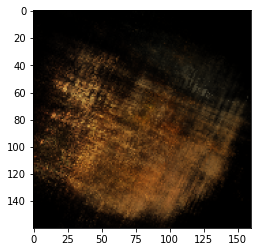

In [29]:
c = render_radiance_field(dataset[30]['imv'], dataset[30]['coords'], radiance_field, dataset.focal, dataset.resolution, dataset.near, dataset.far, train=False)
plt.imshow(c.detach().cpu())

In [30]:
n_epochs = 5
i = 0
training_loss = []
for epoch in range(n_epochs):
  print("Epoch: ", epoch)
  for batch in tqdm(dataloader):
    i += 1
    # get rays
    imvs = batch['imv']
    # print(imvs[:10, :3, -1])
    coords = batch['coords']
    # gettin' rays inside rrf:
    # print(imvs.shape, coords.shape)
    c = render_radiance_field(imvs, coords, radiance_field, dataset.focal, dataset.resolution, dataset.near, dataset.far, train=True)
    
    loss = ((batch['img'] - c) ** 2).sum()
    if i > 0 and i % 200 == 0:
      print(loss.item())
      # print(c.sum().item(), batch['img'].sum().item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_loss.append(loss.item())
    # break

Epoch:  0


 16%|█▌        | 201/1250 [00:21<01:59,  8.80it/s]

55.84276580810547


 32%|███▏      | 401/1250 [00:42<01:23, 10.13it/s]

49.5216064453125


 48%|████▊     | 600/1250 [01:03<01:16,  8.51it/s]

51.01173400878906


 64%|██████▍   | 800/1250 [01:25<00:45,  9.78it/s]

45.10213851928711


 80%|████████  | 1001/1250 [01:46<00:26,  9.47it/s]

38.707305908203125


 96%|█████████▌| 1201/1250 [02:07<00:04, 10.46it/s]

36.92901611328125


100%|██████████| 1250/1250 [02:12<00:00,  9.44it/s]


Epoch:  1


 12%|█▏        | 151/1250 [00:16<01:58,  9.25it/s]

32.101226806640625


 28%|██▊       | 351/1250 [00:37<01:24, 10.67it/s]

31.660493850708008


 44%|████▍     | 550/1250 [00:57<01:18,  8.92it/s]

31.87516975402832


 60%|██████    | 751/1250 [01:19<00:46, 10.84it/s]

26.230178833007812


 76%|███████▌  | 951/1250 [01:40<00:29, 10.17it/s]

27.601686477661133


 92%|█████████▏| 1151/1250 [02:01<00:09, 10.82it/s]

28.041555404663086


100%|██████████| 1250/1250 [02:12<00:00,  9.44it/s]


Epoch:  2


  8%|▊         | 101/1250 [00:10<02:10,  8.79it/s]

23.976478576660156


 24%|██▍       | 300/1250 [00:31<01:28, 10.72it/s]

21.823837280273438


 40%|████      | 501/1250 [00:52<01:24,  8.85it/s]

21.456418991088867


 56%|█████▌    | 701/1250 [01:13<01:04,  8.47it/s]

19.617916107177734


 72%|███████▏  | 901/1250 [01:34<00:39,  8.86it/s]

18.4934139251709


 88%|████████▊ | 1101/1250 [01:55<00:15,  9.64it/s]

21.560386657714844


100%|██████████| 1250/1250 [02:11<00:00,  9.51it/s]


Epoch:  3


  4%|▍         | 51/1250 [00:05<02:15,  8.82it/s]

17.464181900024414


 20%|██        | 251/1250 [00:26<01:46,  9.42it/s]

19.80644989013672


 36%|███▌      | 450/1250 [00:49<01:19, 10.09it/s]

18.84149742126465


 52%|█████▏    | 650/1250 [01:10<01:07,  8.92it/s]

16.223621368408203


 68%|██████▊   | 850/1250 [01:31<00:38, 10.26it/s]

17.548053741455078


 84%|████████▍ | 1050/1250 [01:52<00:20,  9.76it/s]

16.66001319885254


100%|██████████| 1250/1250 [02:13<00:00, 10.37it/s]

16.642105102539062


100%|██████████| 1250/1250 [02:13<00:00,  9.33it/s]


Epoch:  4


 16%|█▌        | 201/1250 [00:21<01:43, 10.13it/s]

15.272795677185059


 32%|███▏      | 401/1250 [00:42<01:19, 10.71it/s]

13.845858573913574


 48%|████▊     | 601/1250 [01:03<01:04, 10.10it/s]

13.951194763183594


 64%|██████▍   | 800/1250 [01:24<00:42, 10.49it/s]

14.64940071105957


 80%|████████  | 1000/1250 [01:45<00:25,  9.84it/s]

13.676708221435547


 96%|█████████▌| 1200/1250 [02:07<00:04, 10.17it/s]

12.857782363891602


100%|██████████| 1250/1250 [02:12<00:00,  9.45it/s]


Ожидаемый результат (после первой эпохи):

<img src="https://drive.google.com/uc?id=1xB23Ta2-NT9muCUtHNAcAo_k4R7KcRYl" style="display: inline-block; text-align: left;"/>

```
epoch: 0, loss=0.002454527420923114
```

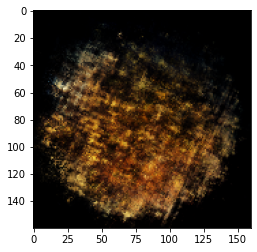

In [31]:
c = render_radiance_field(dataset[30]['imv'], dataset[30]['coords'], radiance_field, dataset.focal, dataset.resolution, dataset.near, dataset.far, train=False)
plt.imshow(c.detach().cpu())

Хот дог превратился в пиццу

Ожидаемый результат (после обучения):

<img src="https://drive.google.com/uc?id=16g098SLeB4knqTyi7ooZpIjXCT5aD-tl" style="display: inline-block; text-align: left;"/>

```
loss=0.00013125527766533196
```